In [13]:
from diskit.components.layer import *
from qiskit import QuantumCircuit, ClassicalRegister

from diskit_updated.circuit_remapper import *

## Grover distributed circuit

In [14]:
def controlled_z(qc, qregs):
    qc.h(qregs['qnode1'][-1])
    qc.mcx([*qregs['qnode0'], *qregs['qnode1'][:-1]], qregs['qnode1'][-1])
    qc.h(qregs['qnode1'][-1])

def diffusion_operator(qc, qregs):
    qc.h(qregs['qnode0'])
    qc.h(qregs['qnode1'])
    qc.x(qregs['qnode0'])
    qc.x(qregs['qnode1'])
    controlled_z(qc, qregs)
    qc.x(qregs['qnode0'])
    qc.x(qregs['qnode1'])
    qc.h(qregs['qnode0'])
    qc.h(qregs['qnode1'])


def get_grover_circuit(qregs):
    qregs_list = qregs.values()
    qc = QuantumCircuit(*qregs_list)

    qc.h(qregs['qnode0'])
    qc.h(qregs['qnode1'])
    
    # Seteamos como valor a buscar el |10>
    qc.x(qregs['qnode0'][0])

    controlled_z(qc, qregs)

    # Seteamos como valor a buscar el |10>
    qc.x(qregs['qnode0'][0])
    
    diffusion_operator(qc, qregs)

    return qc

## WITH 1 QUBIT PER QNODE:

In [15]:
qubits_per_qnode = 1

def create_distributed_topology(qubits_per_qnode):
    circuit_topo = Topology()
    circuit_topo.create_qmap(2, [qubits_per_qnode, qubits_per_qnode], "qnode")

    qregs = {}

    for qpu in circuit_topo.qmap:
        reg = circuit_topo.qmap[qpu][0]._register
        qregs[reg.name] = reg
    for qpu in circuit_topo.emap:
        reg = circuit_topo.emap[qpu]._register
        qregs[reg.name] = reg
    
    return circuit_topo, qregs

circuit_topo, qregs = create_distributed_topology(qubits_per_qnode)
qregs

{'qnode0': QuantumRegister(1, 'qnode0'),
 'qnode1': QuantumRegister(1, 'qnode1'),
 'com_qnode0': QuantumRegister(1, 'com_qnode0'),
 'com_qnode1': QuantumRegister(1, 'com_qnode1')}

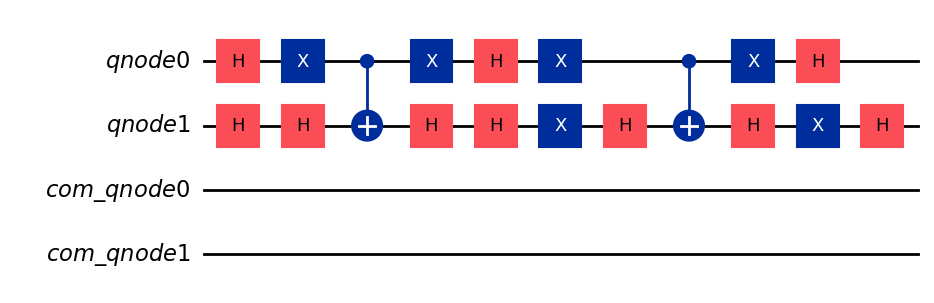

In [16]:
qc = get_grover_circuit(qregs)
qc.draw(output='mpl')

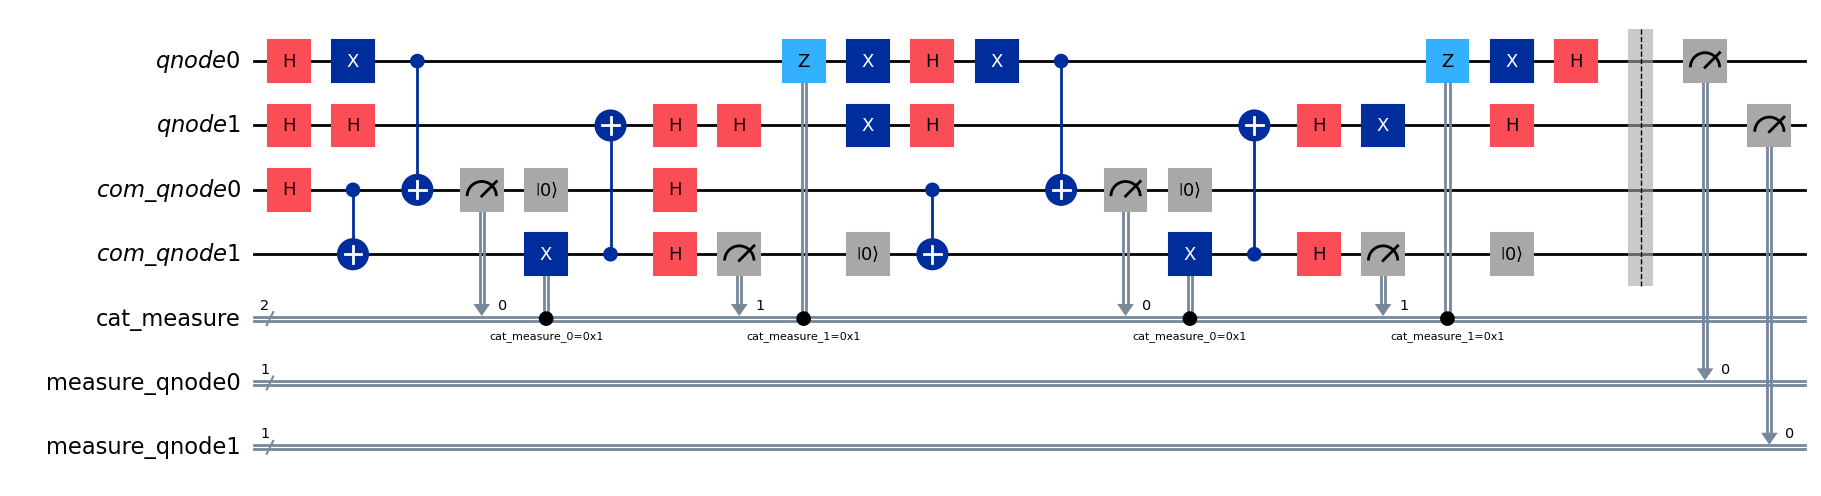

In [17]:
def remap_circuit(circuit_topo, qregs):
    remapper = CircuitRemapper(circuit_topo)
    dist_circ = remapper.remap_circuit(qc)

    measure_reg_q0 = ClassicalRegister(len(qregs['qnode0']), name="measure_qnode0")
    measure_reg_q1 = ClassicalRegister(len(qregs['qnode1']), name="measure_qnode1")
    dist_circ.add_register(measure_reg_q0)
    dist_circ.add_register(measure_reg_q1)
    dist_circ.barrier()
    dist_circ.measure(qregs['qnode0'], measure_reg_q0)
    dist_circ.measure(qregs['qnode1'], measure_reg_q1)

    return dist_circ

dist_circ = remap_circuit(circuit_topo, qregs)
dist_circ.draw(output='mpl')

In [18]:
from qiskit import transpile
from qiskit_aer import Aer

def test_conventional_grover(qregs):
    qc = get_grover_circuit(qregs)
    measure_reg_q0 = ClassicalRegister(len(qregs['qnode0']), name="measure_qnode0")
    measure_reg_q1 = ClassicalRegister(len(qregs['qnode1']), name="measure_qnode1")
    qc.add_register(measure_reg_q0)
    qc.add_register(measure_reg_q1)
    qc.barrier()
    qc.measure(qregs['qnode0'], measure_reg_q0)
    qc.measure(qregs['qnode1'], measure_reg_q1)

    backend = Aer.get_backend('statevector_simulator')
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc, shots=3000)

    return job.result().get_counts()

test_conventional_grover(qregs)

{'1 0': 3000}

In [19]:
def test_distributed_grover(dist_circ, qubits_per_qnode):
    backend = Aer.get_backend('statevector_simulator')
    transpiled_qc = transpile(dist_circ, backend)
    job = backend.run(transpiled_qc, shots=3000)

    counts = job.result().get_counts()

    measurement_final_results = {}
    for key, value in counts.items():
        result_key = key[:qubits_per_qnode*2+1]
        if result_key in measurement_final_results:
            measurement_final_results[result_key] += value
        else:
            measurement_final_results[result_key] = value

    return measurement_final_results

test_distributed_grover(dist_circ, qubits_per_qnode)

{'1 0': 3000}

## WITH 2 QUBIT PER QNODE:

In [20]:
qubits_per_qnode = 2

circuit_topo, qregs = create_distributed_topology(qubits_per_qnode)
qregs

{'qnode0': QuantumRegister(2, 'qnode0'),
 'qnode1': QuantumRegister(2, 'qnode1'),
 'com_qnode0': QuantumRegister(1, 'com_qnode0'),
 'com_qnode1': QuantumRegister(1, 'com_qnode1')}

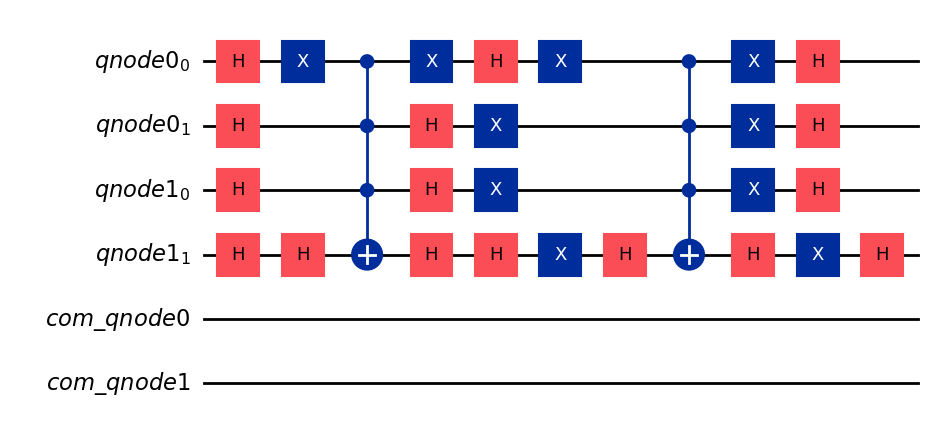

In [21]:
qc = get_grover_circuit(qregs)
qc.draw(output='mpl')

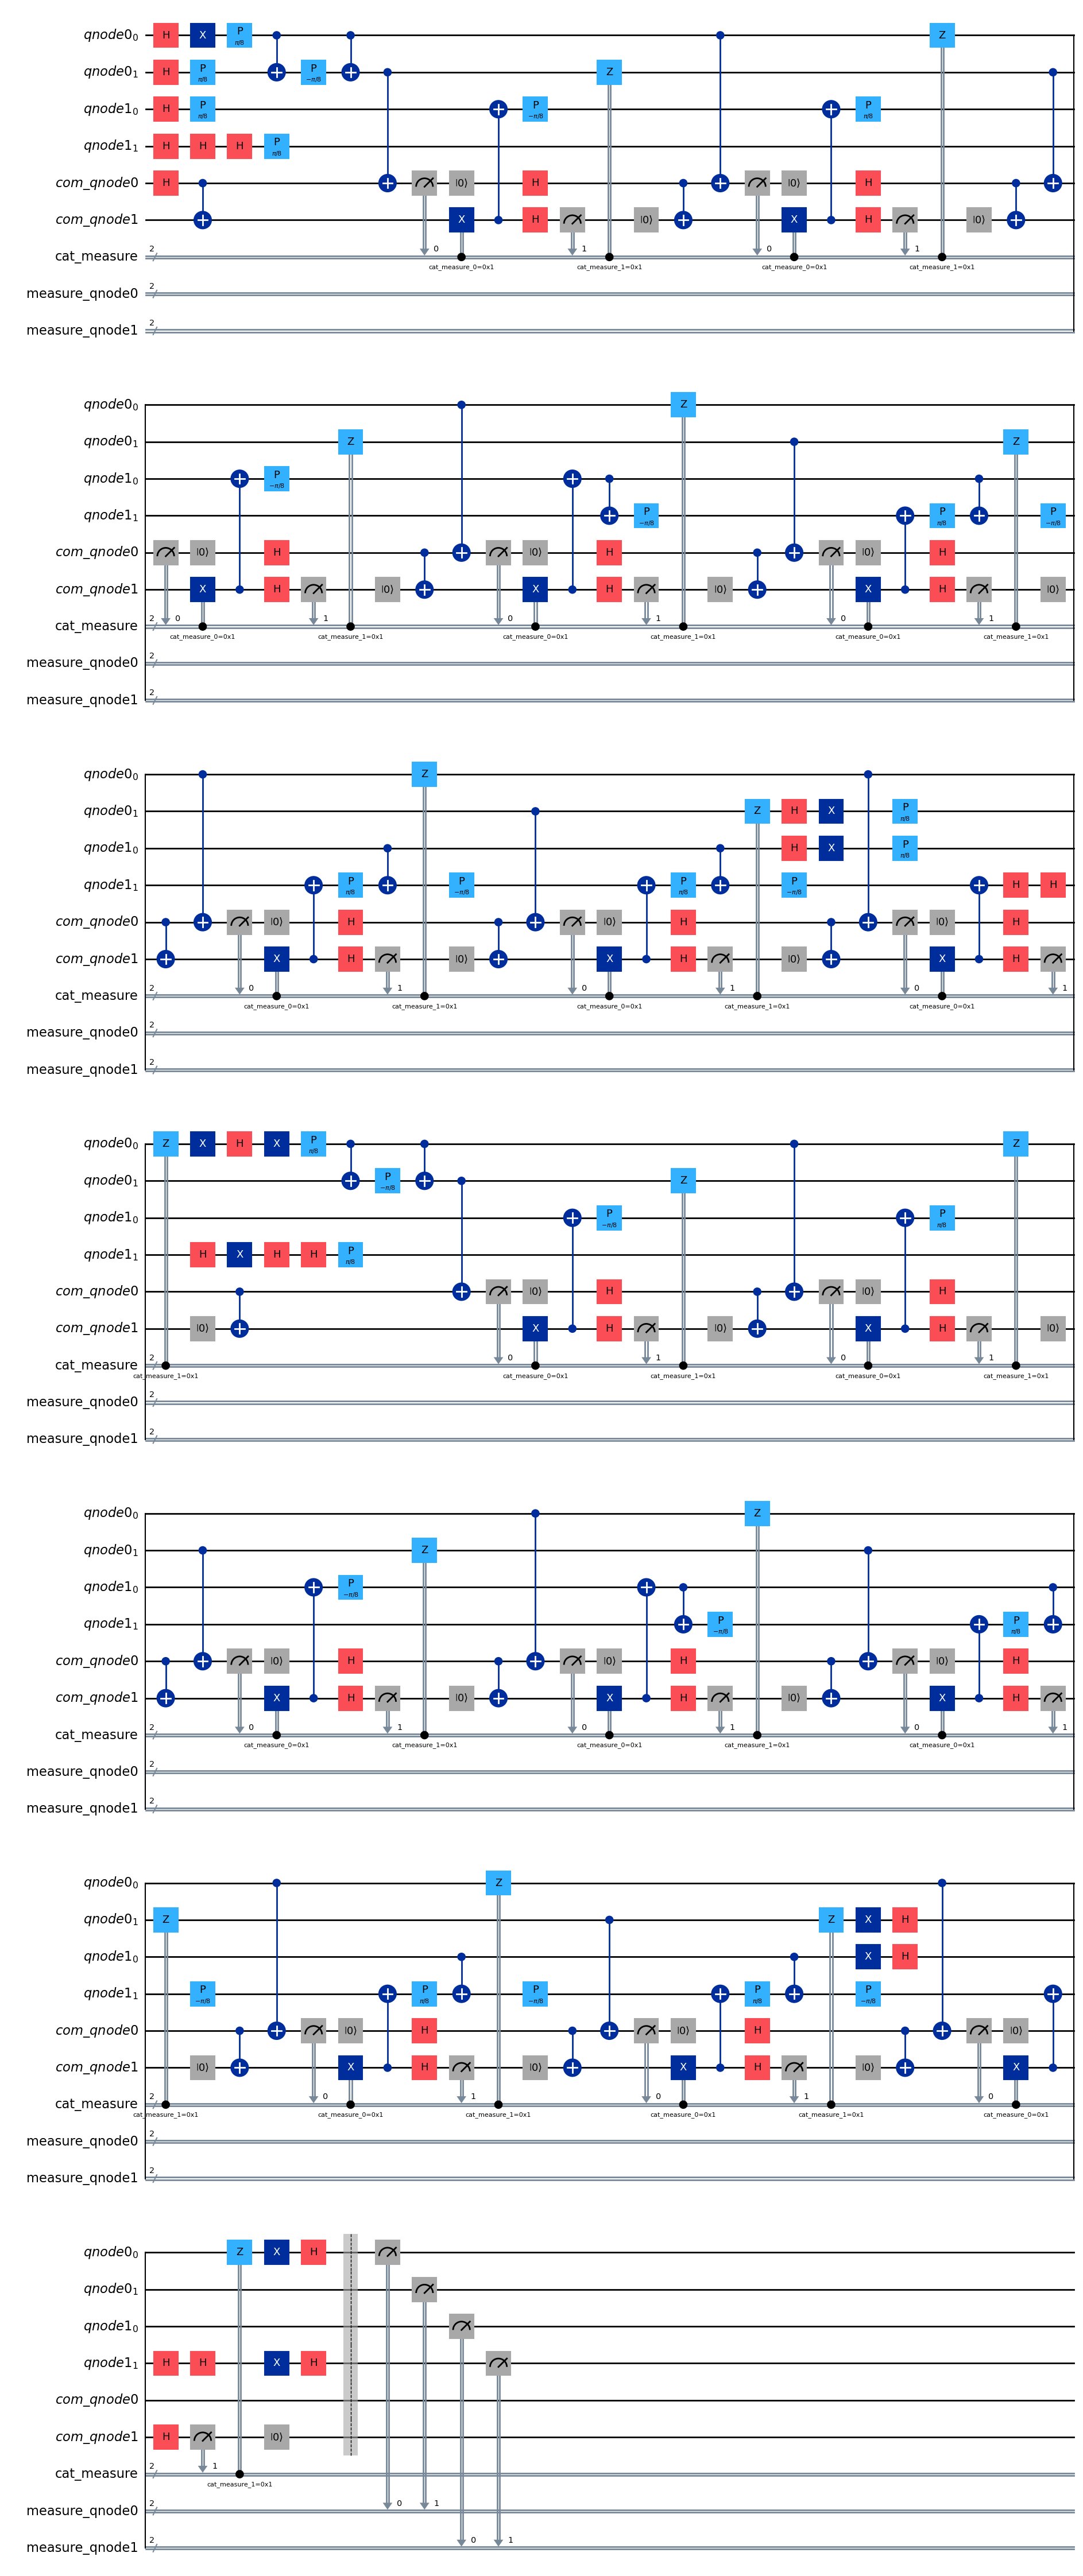

In [22]:
dist_circ = remap_circuit(circuit_topo, qregs)
dist_circ.draw(output='mpl')

In [23]:
test_conventional_grover(qregs)

{'01 01': 103,
 '11 10': 1409,
 '01 10': 123,
 '11 01': 98,
 '00 01': 96,
 '10 10': 123,
 '00 10': 101,
 '00 11': 114,
 '10 11': 101,
 '00 00': 118,
 '11 11': 119,
 '11 00': 108,
 '01 00': 96,
 '10 00': 97,
 '01 11': 96,
 '10 01': 98}

In [24]:
test_distributed_grover(dist_circ, qubits_per_qnode)

{'10 01': 102,
 '00 11': 108,
 '11 10': 1416,
 '11 00': 103,
 '00 01': 107,
 '01 00': 95,
 '11 11': 108,
 '10 00': 113,
 '01 10': 106,
 '01 11': 111,
 '10 10': 90,
 '10 11': 96,
 '00 10': 107,
 '11 01': 113,
 '00 00': 105,
 '01 01': 120}